# Lyft Bay Wheels Biking Sales Analysis

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%%bigquery
SELECT count(*)
FROM `bigquery-public-data.san_francisco.bikeshare_trips`

,f0_
0,983648


In [4]:
%%bigquery sub_types

select subscriber_type, count(trip_id) as trips from `bigquery-public-data.san_francisco.bikeshare_trips` a group by 1 order by trips desc

In [5]:
sub_types['Percent'] = sub_types['trips']/983648

sub_types

,subscriber_type,trips,Percent
0,Subscriber,846839,0.860917
1,Customer,136809,0.139083


Currently, about 86% of Lyft Bay Wheels market are Subscribers so it is important to focus on keeping subscribers happy. In addition, increasing subscribers will be crucial to growing sales. I will be touching on both subscribers and nonsubscribers during my analysis.

# Overall Most Popular Bike Rides

In [7]:
%%bigquery most_pop_rides

select a.start_station_name,
       b.landmark as start_lm,
       a.end_station_name,
       c.landmark as end_lm,
       count(trip_id) as trips
from `bigquery-public-data.san_francisco.bikeshare_trips` a
left join `bigquery-public-data.san_francisco.bikeshare_stations` b
on a.start_station_id = b.station_id
left join `bigquery-public-data.san_francisco.bikeshare_stations` c
on a.end_station_id = c.station_id
group by 1,2,3,4
order by trips desc
limit 10

In [8]:
most_pop_rides

,start_station_name,start_lm,end_station_name,end_lm,trips
0,Harry Bridges Plaza (Ferry Building),San Francisco,Embarcadero at Sansome,San Francisco,9150
1,San Francisco Caltrain 2 (330 Townsend),San Francisco,Townsend at 7th,San Francisco,8508
2,2nd at Townsend,San Francisco,Harry Bridges Plaza (Ferry Building),San Francisco,7620
3,Harry Bridges Plaza (Ferry Building),San Francisco,2nd at Townsend,San Francisco,6888
4,Embarcadero at Sansome,San Francisco,Steuart at Market,San Francisco,6874
5,Townsend at 7th,San Francisco,San Francisco Caltrain 2 (330 Townsend),San Francisco,6836
6,Embarcadero at Folsom,San Francisco,San Francisco Caltrain (Townsend at 4th),San Francisco,6351
7,San Francisco Caltrain (Townsend at 4th),San Francisco,Harry Bridges Plaza (Ferry Building),San Francisco,6215
8,Steuart at Market,San Francisco,2nd at Townsend,San Francisco,6039
9,Steuart at Market,San Francisco,San Francisco Caltrain (Townsend at 4th),San Francisco,5959


 The top 10 most popular trips are in San Francisco and they seem to be in similar stations. Focusing marketing efforts on specifically San Francisco compared to the other landmarks will help to increase sales and grow the user base. 

# Commuters

Next I looked into commuter trips. I defined a commuter as having two trips, one before 12pm and one after. In addition the end location of the first trip must match the start location of the second trip and the end location of second trip matches the start location of first trip. This represents a back and forth type of commute. Lastly, I determined that only subscribers would be commuting because it does not make sense for commuters to get 24 hour or three day memberships if they are going to work five days a week. Below I identify the commuter trips and find which ones are most frequent.

In [20]:
%%bigquery top_commuter_trip

select a.start_station_name,a.end_station_name,b.end_station_name as endd, count(a.trip_id) as trips, trip_back 
from `bigquery-public-data.san_francisco.bikeshare_trips` a 
left join (select start_station_name, 
                end_Station_name, 
                count(trip_id) as trip_back 
                from `bigquery-public-data.san_francisco.bikeshare_trips` 
                where subscriber_type = "Subscriber" and extract(dayofweek from start_date) in (2,3,4,5,6) and extract(hour from start_date) > 12
                group by 1,2)b 
on a.end_Station_name = b.start_Station_name and a.start_station_name = b.end_Station_name 
where a.subscriber_type = "Subscriber" and extract(dayofweek from start_date) in (2,3,4,5,6) and extract(hour from start_date) < 13 group by 1,2,3,5 order by trips desc limit 100

In [21]:
top_commuter_trip

,start_station_name,end_station_name,endd,trips,trip_back
0,Harry Bridges Plaza (Ferry Building),2nd at Townsend,Harry Bridges Plaza (Ferry Building),5022,5202
1,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,San Francisco Caltrain 2 (330 Townsend),4563,4184
2,San Francisco Caltrain (Townsend at 4th),Temporary Transbay Terminal (Howard at Beale),San Francisco Caltrain (Townsend at 4th),4473,4301
3,Steuart at Market,2nd at Townsend,Steuart at Market,4409,2886
4,Market at Sansome,2nd at South Park,Market at Sansome,3841,4145
...,...,...,...,...,...
95,San Francisco Caltrain (Townsend at 4th),Post at Kearny,San Francisco Caltrain (Townsend at 4th),873,1010
96,Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),Embarcadero at Folsom,872,550
97,Powell at Post (Union Square),Howard at 2nd,Powell at Post (Union Square),861,200
98,Beale at Market,Commercial at Montgomery,Beale at Market,861,317


In [22]:
top_commuter_trip['total_commuter_trip'] = top_commuter_trip['trips']+top_commuter_trip['trip_back']
top_commuter_trip.sort_values(by=['total_commuter_trip'], ascending= False).head(5).reset_index().drop('index', axis=1)

,start_station_name,end_station_name,endd,trips,trip_back,total_commuter_trip
0,Harry Bridges Plaza (Ferry Building),2nd at Townsend,Harry Bridges Plaza (Ferry Building),5022,5202,10224
1,San Francisco Caltrain (Townsend at 4th),Embarcadero at Folsom,San Francisco Caltrain (Townsend at 4th),3753,5156,8909
2,San Francisco Caltrain (Townsend at 4th),Temporary Transbay Terminal (Howard at Beale),San Francisco Caltrain (Townsend at 4th),4473,4301,8774
3,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,San Francisco Caltrain 2 (330 Townsend),4563,4184,8747
4,Steuart at Market,Embarcadero at Sansome,Steuart at Market,3227,4811,8038


By looking at the top commuter trips we can determine where our subscribers are going and have special offers to keep them happy. The commuter trips should be priced lower than non-commuter trips due to more usage. In turn, commuters will promote our great prices and ease of use to their coworkers to grow our market. Having a strong subscriber growth is essential in growing the company and increasing profits.

# Non-Commuters(tourists or locals)

Although subscribers make up a large portion of people who use our product, we can also increase sales through a higher pricing model to people who do not have an annual or monthly subscription. This can be tourists or locals who only need to get around the city for 1-2 days at a time. 

In [11]:
%%bigquery customer_week

select extract (dayofweek from a.start_Date) as day,
      count(a.trip_id) as customer_trips,
      b.subscriber_trip
from `bigquery-public-data.san_francisco.bikeshare_trips` a 
left join (select extract (dayofweek from start_Date) as day,
                  count(trip_id) as subscriber_trip
        from `bigquery-public-data.san_francisco.bikeshare_trips`
        where subscriber_type = "Subscriber"
        group by 1) b
on extract(dayofweek from a.start_Date) = b.day
where a.subscriber_type = "Customer"
group by 1,3
order by day asc

Text(0.5, 1.0, 'Customer Trip Days')

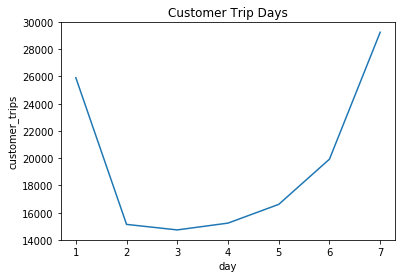

In [12]:
customer_week_1 = customer_week.drop('subscriber_trip', axis=1)
customer_week_2 = customer_week.drop('customer_trips', axis=1)

sns.lineplot(x='day',y='customer_trips',data=customer_week_1).set_title("Customer Trip Days")


Text(0.5, 1.0, 'Subscriber Trip Days')

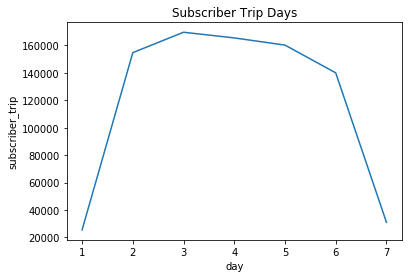

In [13]:
sns.lineplot(x='day', y='subscriber_trip', data=customer_week_2).set_title("Subscriber Trip Days")

In [24]:
customer_week

,day,customer_trips,subscriber_trip
0,1,25908,25467
1,2,15142,154795
2,3,14737,169668
3,4,15237,165530
4,5,16612,160296
5,6,19929,140048
6,7,29244,31035


From the two graphs, customers (24hour-3day) use Lyft Bay Wheels more on weekends when compared to subscribers that use it mostly on weekdays. This might be attributed to tourists visiting San Francisco and SF residents going out on the weekends over weekdays. There is a huge potential to grow the platform towards even more tourists on weekends and increase customer growth. Below, I show the top 5 trips on weekends for customers that can be used as a marketing tool to show how easy it is to get around. 

In [25]:
%%bigquery top_customer_trip_weekend

select a.start_station_name, a.end_station_name, count(trip_id) as trips 
from `bigquery-public-data.san_francisco.bikeshare_trips` a 
where extract(dayofweek from start_date) in (1,7) 
group by 1,2 
order by trips desc 
limit 5

In [26]:
top_customer_trip_weekend

,start_station_name,end_station_name,trips
0,Harry Bridges Plaza (Ferry Building),Embarcadero at Sansome,2078
1,Embarcadero at Sansome,Harry Bridges Plaza (Ferry Building),1183
2,Embarcadero at Sansome,Embarcadero at Sansome,1146
3,Harry Bridges Plaza (Ferry Building),Harry Bridges Plaza (Ferry Building),1122
4,Embarcadero at Bryant,Embarcadero at Sansome,701


# Monthly and Daily Trends

We can further look into the times of day for weekends when it is popular and do a monthly trend analysis.

In [47]:
%%bigquery time_of_day

select extract(hour from start_date) as hour, count(trip_id) as trips from `bigquery-public-data.san_francisco.bikeshare_trips` a where extract(dayofweek from start_date) in (1,7) group by 1 order by hour asc


Text(0.5, 1.0, 'Hour of Day')

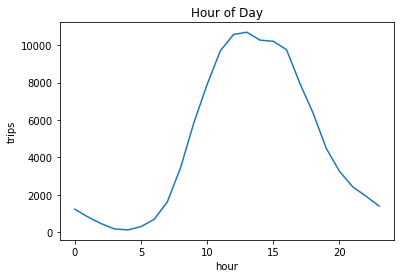

In [28]:
sns.lineplot(x='hour', y='trips', data=time_of_day).set_title("Hour of Day")

During weekends the most popular hours of the day are between 10:00 and 15:00 military time. Lyft should try to market their products competitively during peak hours to try and increase profits. This includes both subscribers and customers as most people do not work during weekends and are trying to explore the city.

Next I did an analysis based on monthly trends.

In [15]:
%%bigquery monthly

select date(extract(year from start_date),extract(month from start_date),1) as date, count(trip_id) as trips 
from `bigquery-public-data.san_francisco.bikeshare_trips` 
where date(extract(year from start_date),extract(month from start_date),1) <> "2013-08-01" 
group by 1 
order by date asc

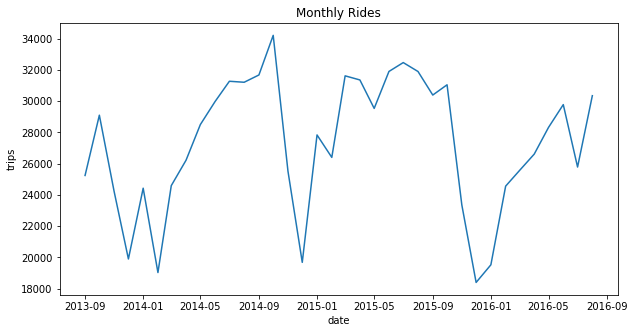

In [18]:
plt.figure(figsize=(10,5))
ax = sns.lineplot(x='date',y='trips', data=monthly).set_title('Monthly Rides')

The graph above shows monthly rides from September 2013 to September 2016. We can see a strong seasonal trend amongst all users. There seems to be a consistent dip between the months of November through January for the past 3 years. This could be due to weather getting slightly colder and rainier during the winter months. We can take this information and run promotions to try and increase trips during these off months or use the time to improve stations and repair bikes. 

# Final Suggestions

My recommendations for offers is to have 1 day, 3 day, commuter option, and annual pass. The 1 and 3 days passes are specifically marketed towards tourists who are on vacation and users who do not need the commuter option. This gives them the opportunity to only pay for weekends where they want to explore the city. Also, the 1 and 3 day passes will be priced slightly higher per day than the commuter and annual pass option. Lastly, focusing marketing efforts on weekends and showing the various places that Lyft Bay Wheel Stations are available will provide new customers with a plan to explore as much of the city as possible in the limited time they have.

For the commuter option, this will be specifically marketed towards those who commute to work everyday. This pass gives 2 rides per day excluding weekends as a monthly flat rate subscription. Additional rides on weekends can be purchased at a discounted rate. From the above top 5 commuter routes, we see that all of the top commuter routes are above 8000 trips. By having this option for commuters, we can have a steady revenue base while also providing a convenient and eco-friendly way for them to travel. 

The last option Lyft Bay Wheels should offer is the annual pass. This pass is marketed towards those who commute but also like to get out an explore the city every weekend. This pass is a flat annual fee that boasts up to 4 rides per day including weekends. This is for those who commute but also are active on the weekends. 

These 4 pass options will help Lyft Bay Wheels continue their subscriber growth in addition to getting into new customer markets. On the last graph regarding monthly usages, Lyft should offer promotions during the winter season months to get more people using the product. This can be done by giving annual pass users options to give their friend a free ride or do have discounted rates for 1 or 3 day passes.